# Scaled Word Usages

_Date: September 10, 2024_

We are interested in modelling topics (or mixed membership clusters) from word count data.
However, we consider the case when words have differently dispersed usages.
We can imagine that in these cases, relative changes in word usage are more informative than absolute word usage.

We have a total of $V$ words used in our corpus of $M$ documents. Each word is observed to have a maximum per document usage of $C_v$.
Let $x_{mv} \in \mathbb{N}_+$ denote the counts of word $v$ in document $m$, where $\sum_v x_{mv} = N_m$, for the total number of words in the document $N_m$.
We consider the following two models:

**A. Fraction-of-max binomial model.**
\begin{align*}
\mathbf{\theta}_k &\sim \in \Delta^V, \mathbf{\beta}_{m} \in \mathbb{R}^K\\
p_{mv} &= \sigma\left(\sum_k \beta_{mk} \theta_{kv} + \theta^0_v\right) \in [0,1]\\
x_{mv} &\sim \textrm{Bin}(C_v, p_{mv})
\end{align*}
where $\theta^0 \in \mathbb{R}^V$ is a real-valued vector of baseline word usage (relative to max usage),
$\theta_k \in \mathbb{R}^V_+$ is the change in word usage (relative to baseline) defining a topic,
and $\sigma: \mathbb{R}\rightarrow [0,1]$ is the sigmoid function.

When the maximum word usage is the same from all words, $C_v = C_{v'}$ for all $v'=1,...,V$, then we expect LDA to recover the model parameters.


**B. Scaled Poisson rate model 1.**
\begin{align*}
\mathbf{\theta}_k &\in \Delta^V, \mathbf{\beta}_m \in \Delta^K, C_v \in \mathbb{R}_+ \\
\lambda_{mv} &= \textstyle{\sum_k} \beta_{mk} \theta_{kv}, \mathbf{\lambda}_{m} \in \Delta_V \\
x_{mv} &\sim \textrm{Poi}\left(C_v\lambda_{mv}\right)
\end{align*}

While max word usage $C_v$ was proposed to be drawn from a Gamma, since it represents the max usage, a extreme value distribution such as a Gumbel distribution may also be considered.

**C. Scaled Poisson rate model 2.**
\begin{align*}
\mathbf{\theta}_k & \in \Delta^V, \mathbf{\beta}_m \in \mathbb{R}_+^K, \mathbf{\gamma} \in \Delta_V, C_v\in\mathbb{N}_+ \\
\lambda_{mv} &= \textstyle{\sum_k} \beta_{mk} \theta_{kv} \in \mathbb{R}_+ \\
x_{mv} &\sim \textrm{Poi}\left(C_v\gamma_v\lambda_{mv}\right)
\end{align*}

This model is similar to B., but it places the simplex constraint over scaling weights $\mathbf{\gamma}$ instead of over topic loadings $\mathbf{\beta}_m$.

In [1]:
from jax import vmap
import jax.nn
import jax.numpy as jnp
import jax.random as jr
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import cross_val_score
import tensorflow_probability.substrates.jax.distributions as tfd

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
V = 10   # vocab size
K = 2    # num topics
M = 100   # num documents
C = 100  # max word usages, shared

# generate data
key = jr.key(42)

## 

## A. Fraction-of-max binomial model

### Model A with normal distributed weights

In [13]:
def generate_data_a_normal(key, n_docs, n_topics, vocab_size, max_word_count):
    k1, k2, k3 = jr.split(key, 3)

    if isinstance(max_word_count, (int, float)):
        max_word_count = max_word_count * jnp.ones(vocab_size)
    
    baseline = -0.1 * jnp.ones(vocab_size)   # theta_nought
    topics = jr.dirichlet(k1, jnp.ones(vocab_size), shape=(n_topics,))

    # weights = jr.uniform(k2, (n_docs, n_topics), minval=-10, maxval=1)
    weights = 3 * jr.normal(k2, shape=(n_docs, n_topics))

    probs = jax.nn.sigmoid(weights@topics + baseline)  # shape (M,V)
    data = jr.binomial(k3, max_word_count, probs)

    params = dict(
        baseline=baseline,
        topics=topics,
        weights=weights,
    )

    return data, params

data_a_normal, params_a_normal = generate_data_a_normal(key, M, K, V, C)

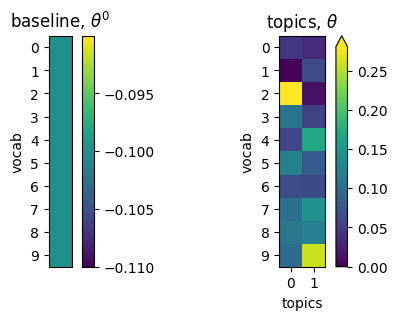

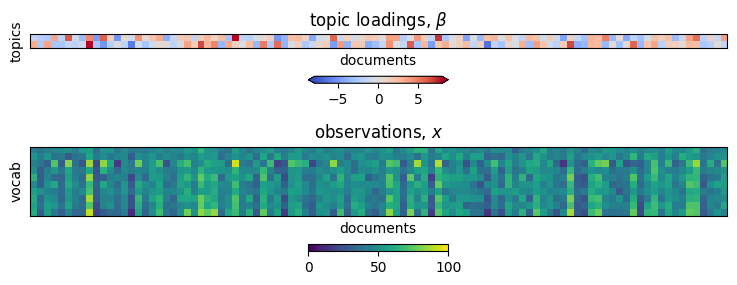

In [14]:
# baseline and relative topics
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3),)

# baseline usage
ax = axs[0]
im = ax.imshow(params_a_normal['baseline'][:,None])
ax.tick_params(bottom=False, labelbottom=False)
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"baseline, $\theta^0$")
plt.colorbar(im, ax=ax)

# relative usage
ax = axs[1]
im = ax.imshow(params_a_normal['topics'].T, vmin=0)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

plt.show()

# -------------------------------------------

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,4),)

# topic loadings, beta
ax = axs[0]
weights_vmax = jnp.max(jnp.abs(params_a_normal['weights']))
im = ax.imshow(params_a_normal['weights'].T, vmin=-weights_vmax, vmax=weights_vmax, cmap="coolwarm")
ax.set_ylabel('topics'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
ax.set_title(r'topic loadings, $\beta$')
plt.colorbar(im, ax=ax, fraction=0.05, extend='both', location='bottom', pad=0.2)

# word usages, x
ax = axs[1]
im = ax.imshow(data_a_normal.T, vmin=0, vmax=C)
ax.set_ylabel('vocab'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
plt.colorbar(im, ax=ax, fraction=0.05, location='bottom', pad=0.2)
ax.set_title(r'observations, $x$');

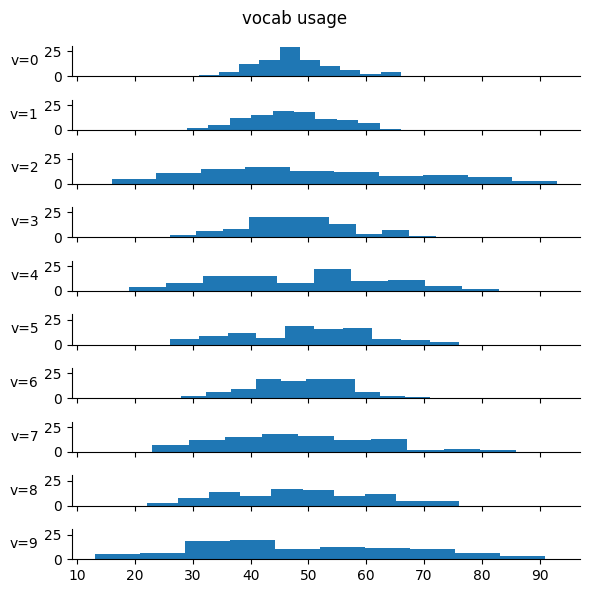

In [15]:
# word usage histogram
fig, axs = plt.subplots(
    nrows=V, ncols=1, figsize=(6,6),
    sharex=True, sharey=True
)

for v, ax in enumerate(axs):
    ax.hist(data_a_normal[:,v])
    ax.set_ylabel(f"{v=}", rotation=0, ha='right', va='center')
    ax.spines[['top', 'right']].set_visible(False)

fig.suptitle("vocab usage")
plt.tight_layout()

The LDA model may not fit well because the observed counts of the data are not right-skewed.

#### Fit with LDA

In [16]:
## Fit an LDA model now
lda_components = [2,3]
lda_topics = []
for n_components in lda_components:
    lda = LDA(n_components=n_components)
    lda.fit(data_a_normal)
    lda_topics.append(lda.components_ / lda.components_.sum(axis=-1, keepdims=True))

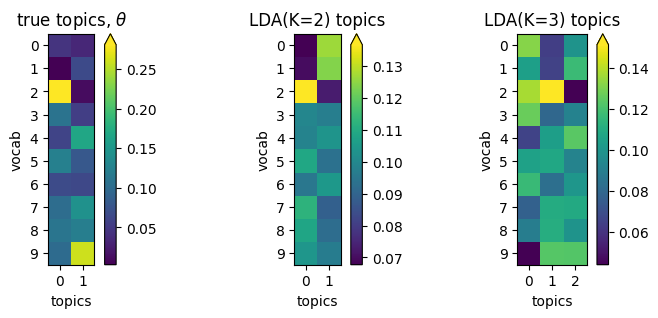

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=len(lda_topics)+1, figsize=(9,3))

# true
ax = axs[0]
im = ax.imshow(params_a_normal['topics'].T)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"true topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

for ax, n_components, topics in zip(axs[1:], lda_components, lda_topics):
    im = ax.imshow(topics.T)
    ax.set_xlabel("topics"); ax.set_xticks(range(n_components))
    ax.set_ylabel("vocab"); ax.set_yticks(range(V))
    ax.set_title(f"LDA(K={n_components}) topics")
    plt.colorbar(im, ax=ax, extend='max')

While LDA is capture some characteristics of the true topics (e.g. upweights on words 2 and 3), 
the remainder of the topics are captured by the complement. This can be understood by the fact that LDA is a purely non-negative, additive model.

However, it feels like we aren't completely doing LDA justice -- perhaps we should just check if there is some linear combination of the K+1 topics that captures the original topics?

### Model A with right-skewed weights

In [18]:
def generate_data_a_skewed(key, n_docs, n_topics, vocab_size, max_word_count):
    k1, k2, k3 = jr.split(key, 3)

    if isinstance(max_word_count, (int, float)):
        max_word_count = max_word_count * jnp.ones(vocab_size)
    
    baseline = -0.1 * jnp.ones(vocab_size)   # theta_nought
    topics = jr.dirichlet(k1, jnp.ones(vocab_size), shape=(n_topics,))

    weights = jr.uniform(k2, (n_docs, n_topics), minval=-10, maxval=1)

    probs = jax.nn.sigmoid(weights@topics + baseline)  # shape (M,V)
    data = jr.binomial(k3, max_word_count, probs)

    params = dict(
        baseline=baseline,
        topics=topics,
        weights=weights,
    )

    return data, params

data_a_skewed, params_a_skewed = generate_data_a_skewed(key, M, K, V, C)

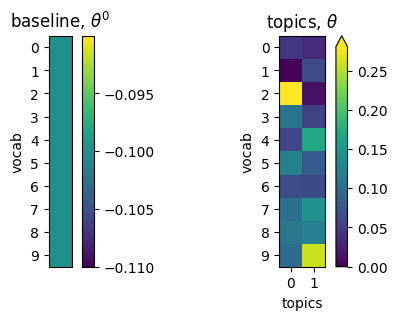

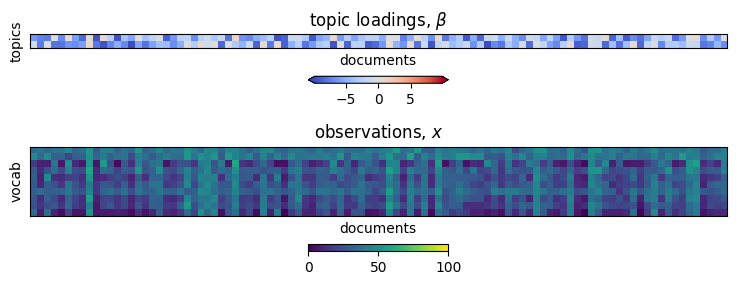

In [19]:
# baseline and relative topics
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3),)

# baseline usage
ax = axs[0]
im = ax.imshow(params_a_skewed['baseline'][:,None])
ax.tick_params(bottom=False, labelbottom=False)
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"baseline, $\theta^0$")
plt.colorbar(im, ax=ax)

# relative usage
ax = axs[1]
im = ax.imshow(params_a_skewed['topics'].T, vmin=0)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

plt.show()

# -------------------------------------------

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,4),)

# topic loadings, beta
ax = axs[0]
weights_vmax = jnp.max(jnp.abs(params_a_skewed['weights']))
im = ax.imshow(params_a_skewed['weights'].T, vmin=-weights_vmax, vmax=weights_vmax, cmap="coolwarm")
ax.set_ylabel('topics'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
ax.set_title(r'topic loadings, $\beta$')
plt.colorbar(im, ax=ax, fraction=0.05, extend='both', location='bottom', pad=0.2)

# word usages, x
ax = axs[1]
im = ax.imshow(data_a_skewed.T, vmin=0, vmax=C)
ax.set_ylabel('vocab'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
plt.colorbar(im, ax=ax, fraction=0.05, location='bottom', pad=0.2)
ax.set_title(r'observations, $x$');

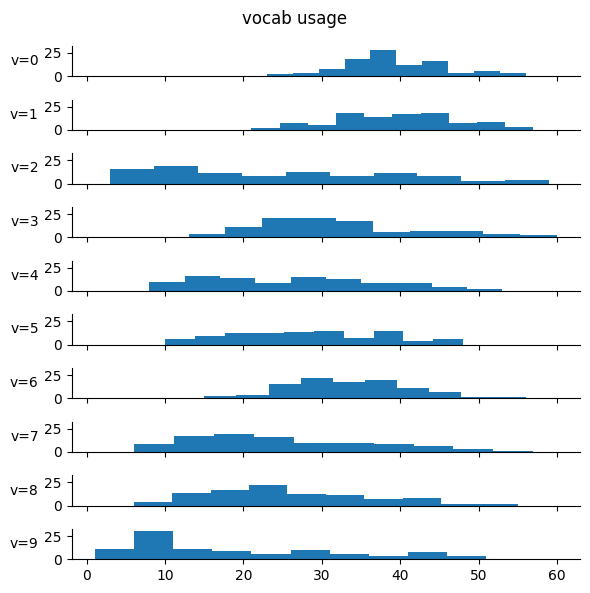

In [21]:
# word usage histogram
fig, axs = plt.subplots(
    nrows=V, ncols=1, figsize=(6,6),
    sharex=True, sharey=True
)

for v, ax in enumerate(axs):
    ax.hist(data_a_skewed[:,v])
    ax.set_ylabel(f"{v=}", rotation=0, ha='right', va='center')
    ax.spines[['top', 'right']].set_visible(False)

fig.suptitle("vocab usage")
plt.tight_layout()

#### Fit with LDA

In [22]:
## Fit an LDA model now
lda_components = [2,3]
lda_topics = []
for n_components in lda_components:
    lda = LDA(n_components=n_components)
    lda.fit(data_a_skewed)
    lda_topics.append(lda.components_ / lda.components_.sum(axis=-1, keepdims=True))

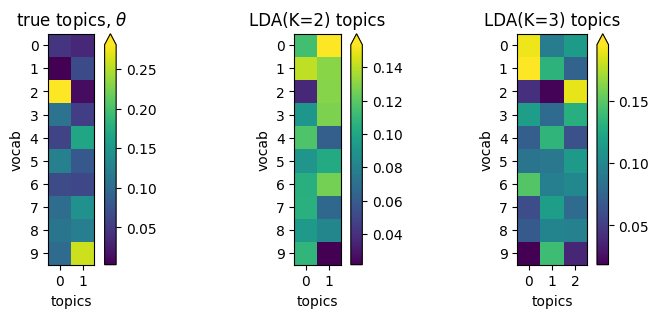

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=len(lda_topics)+1, figsize=(9,3))

# true
ax = axs[0]
im = ax.imshow(params_a_skewed['topics'].T)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"true topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

for ax, n_components, topics in zip(axs[1:], lda_components, lda_topics):
    im = ax.imshow(topics.T)
    ax.set_xlabel("topics"); ax.set_xticks(range(n_components))
    ax.set_ylabel("vocab"); ax.set_yticks(range(V))
    ax.set_title(f"LDA(K={n_components}) topics")
    plt.colorbar(im, ax=ax, extend='max')

Skewing the weights (and therefore the vocab usage) does not seem to improve model fit.

## B. Scaled Poisson rate model 1

In [24]:
def generate_data_b(key, n_docs, n_topics, vocab_size, max_word_count):
    k1, k2, k3, = jr.split(key, 3)

    if isinstance(max_word_count, (int, float)):
        max_word_count = max_word_count * jnp.ones(vocab_size)
    
    topics = jr.dirichlet(k1, jnp.ones(V), shape=(K,))   # theta_k's, shape (K,V)
    weights = jr.dirichlet(k2, jnp.ones(K), shape=(M,))  # beta_m's, shape (M,K)
    
    data = jr.poisson(k3, max_word_count * (weights @ topics))
    params = dict(
        topics=topics,
        weights=weights,
    )

    return data, params

data_b, params_b = generate_data_b(key, M, K, V, C)

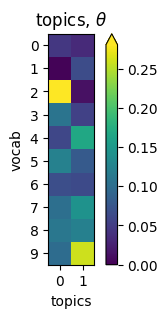

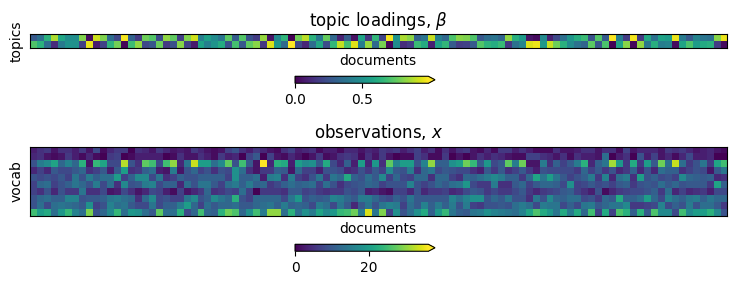

In [25]:
# baseline and relative topics
plt.figure(figsize=(3,3))
ax = plt.gca()

# relative usage
im = ax.imshow(params_b['topics'].T, vmin=0)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

plt.show()

# -------------------------------------------

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,4),)

# topic loadings, beta
ax = axs[0]
im = ax.imshow(params_b['weights'].T, vmin=0)
ax.set_ylabel('topics'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
ax.set_title(r'topic loadings, $\beta$')
plt.colorbar(im, ax=ax, fraction=0.05, extend='max', location='bottom', pad=0.2)

# word usages, x
ax = axs[1]
im = ax.imshow(data_b.T, vmin=0)
ax.set_ylabel('vocab'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
plt.colorbar(im, ax=ax, fraction=0.05, location='bottom', pad=0.2, extend='max')
ax.set_title(r'observations, $x$');

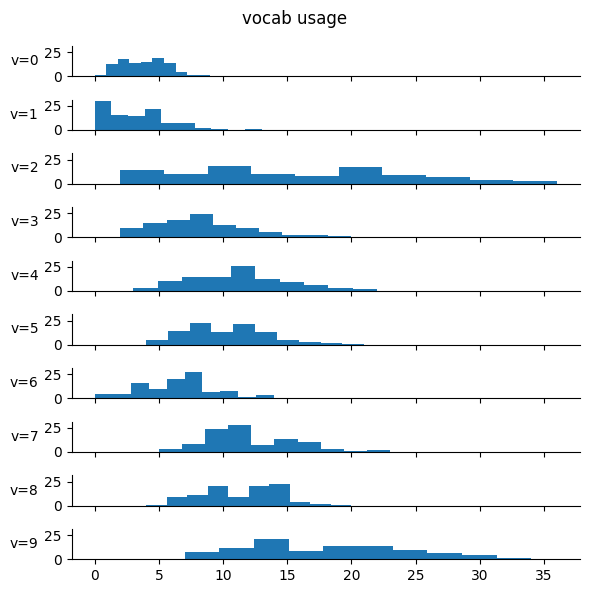

In [26]:
# word usage histogram
fig, axs = plt.subplots(
    nrows=V, ncols=1, figsize=(6,6),
    sharex=True, sharey=True
)

for v, ax in enumerate(axs):
    ax.hist(data_b[:,v])
    ax.set_ylabel(f"{v=}", rotation=0, ha='right', va='center')
    ax.spines[['top', 'right']].set_visible(False)

fig.suptitle("vocab usage")
plt.tight_layout()

Counts per document for each word $v$ is appears to be well-described by a Poisson distribution.

#### Fit with LDA

In [27]:
## Fit an LDA model now
lda_components = [2,3]
lda_topics = []
for n_components in lda_components:
    lda = LDA(n_components=n_components)
    lda.fit(data_b)
    lda_topics.append(lda.components_ / lda.components_.sum(axis=-1, keepdims=True))

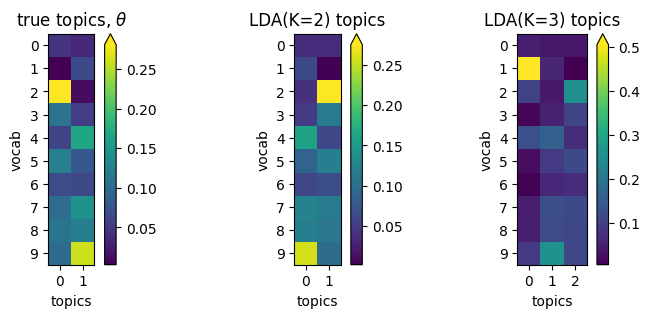

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=len(lda_topics)+1, figsize=(9,3))

# true
ax = axs[0]
im = ax.imshow(params_b['topics'].T)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"true topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

for ax, n_components, topics in zip(axs[1:], lda_components, lda_topics):
    im = ax.imshow(topics.T)
    ax.set_xlabel("topics"); ax.set_xticks(range(n_components))
    ax.set_ylabel("vocab"); ax.set_yticks(range(V))
    ax.set_title(f"LDA(K={n_components}) topics")
    plt.colorbar(im, ax=ax, extend='max')

Here, LDA appears to recover the topics of the scaled Poisson model.

## C. Scaled Poisson rate model 2

In [29]:
# generate data from model
def generate_data_c(key, n_docs, n_topics, vocab_size, max_word_count):
    k1, k2, k3, k4 = jr.split(key, 4)

    if isinstance(max_word_count, (int, float)):
        max_word_count = max_word_count * jnp.ones(vocab_size)
    
    topics = jr.dirichlet(k1, jnp.ones(V), shape=(K,))   # theta_k's, shape (K,V)
    weights = jr.gamma(k2, 1, shape=(M,K))
    gammas = jr.dirichlet(k3, jnp.ones(V))   # theta_k's, shape (K,V)

    data = jr.poisson(k4, max_word_count * gammas * (weights @ topics))

    params = dict(
        gammas=gammas,
        topics=topics,
        weights=weights,
    )

    return data, params

data_c, params_c = generate_data_c(key, M, K, V, C)

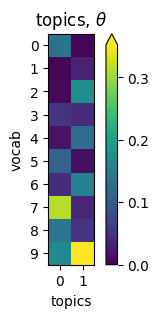

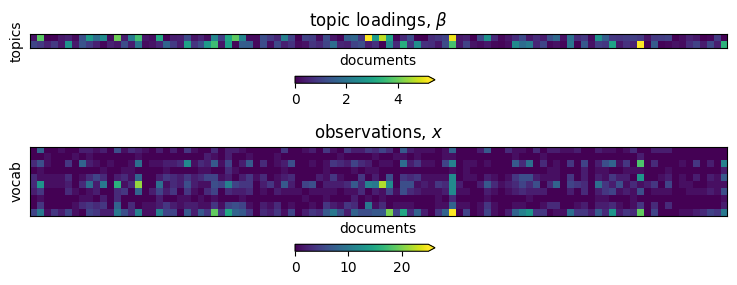

In [30]:
# baseline and relative topics
plt.figure(figsize=(3,3))
ax = plt.gca()

# relative usage
im = ax.imshow(params_c['topics'].T, vmin=0)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

plt.show()

# -------------------------------------------

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,4),)

# topic loadings, beta
ax = axs[0]
im = ax.imshow(params_c['weights'].T, vmin=0)
ax.set_ylabel('topics'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
ax.set_title(r'topic loadings, $\beta$')
plt.colorbar(im, ax=ax, fraction=0.05, extend='max', location='bottom', pad=0.2)

# word usages, x
ax = axs[1]
im = ax.imshow(data_c.T, vmin=0)
ax.set_ylabel('vocab'); ax.set_yticks([])
ax.set_xlabel('documents'); ax.set_xticks([])
plt.colorbar(im, ax=ax, fraction=0.05, location='bottom', pad=0.2, extend='max')
ax.set_title(r'observations, $x$');

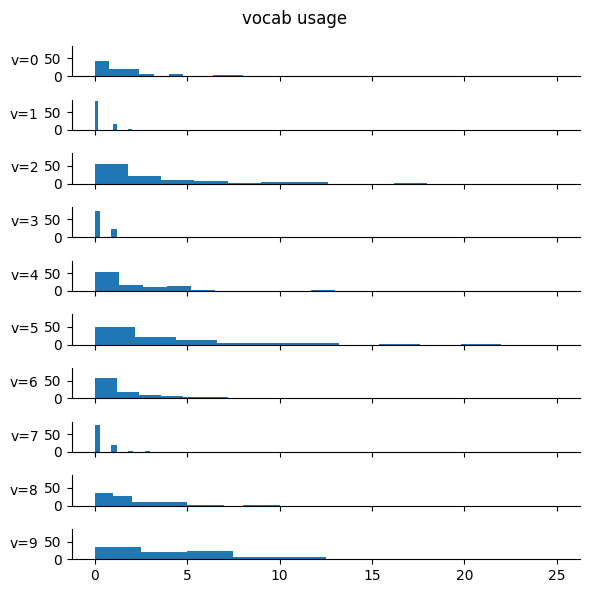

In [31]:
# word usage histogram
fig, axs = plt.subplots(
    nrows=V, ncols=1, figsize=(6,6),
    sharex=True, sharey=True
)

for v, ax in enumerate(axs):
    ax.hist(data_c[:,v])
    ax.set_ylabel(f"{v=}", rotation=0, ha='right', va='center')
    ax.spines[['top', 'right']].set_visible(False)

fig.suptitle("vocab usage")
plt.tight_layout()

#### Fit LDA

In [32]:
## Fit an LDA model now
lda_components = [2,3]
lda_topics = []
for n_components in lda_components:
    lda = LDA(n_components=n_components)
    lda.fit(data_c)
    lda_topics.append(lda.components_ / lda.components_.sum(axis=-1, keepdims=True))

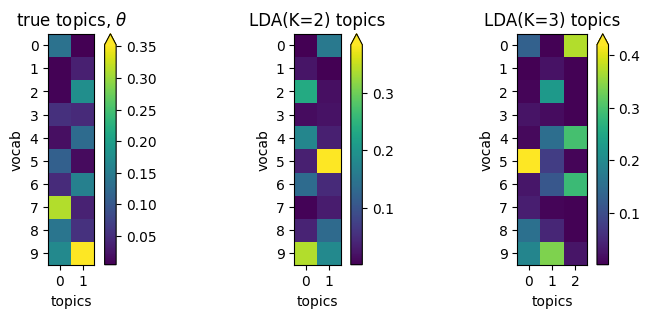

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=len(lda_topics)+1, figsize=(9,3))

# true
ax = axs[0]
im = ax.imshow(params_c['topics'].T)
ax.set_xlabel("topics"); ax.set_xticks(range(K))
ax.set_ylabel("vocab"); ax.set_yticks(range(V))
ax.set_title(r"true topics, $\theta$")
plt.colorbar(im, ax=ax, extend='max')

for ax, n_components, topics in zip(axs[1:], lda_components, lda_topics):
    im = ax.imshow(topics.T)
    ax.set_xlabel("topics"); ax.set_xticks(range(n_components))
    ax.set_ylabel("vocab"); ax.set_yticks(range(V))
    ax.set_title(f"LDA(K={n_components}) topics")
    plt.colorbar(im, ax=ax, extend='max')

### Intermediate Conclusions
It appears that model B, "scaled Poisson rate model 2" where the loading weights have the same Dirichlet prior as in LDA, is the only model that LDA can exactly recover.

Here, we reiterate model B:
\begin{align*}
\mathbf{\theta}_k &\in \Delta^V, \mathbf{\beta}_m \in \Delta^K, C_v \in \mathbb{R}_+ \\
\lambda_{mv} &= \textstyle{\sum_k} \beta_{mk} \theta_{kv}, \mathbf{\lambda}_{m} \in \Delta_V \\
x_{mv} &\sim \textrm{Poi}\left(C_v\lambda_{mv}\right)
\end{align*}

In the following section, we examine how LDA mode fits as we vary max word usage count for each word, $C_v$.

In [34]:
rates = params_b['weights'] @ params_b['topics']
rates.shape

(100, 10)

In [36]:
rates.sum(axis=0)

Array([ 3.9617882,  3.349608 , 15.016556 ,  8.216768 , 11.193499 ,
       10.186875 ,  6.4879584, 12.206327 , 11.639899 , 17.740723 ],      dtype=float32)